In [1]:
import os
os.environ['PATH'] = "/Library/TeX/texbin:" + os.environ['PATH']
puzzles_second_movement = None

In [190]:
import pickle
import random
from pathlib import Path
import colorsys

import chess
import iceberg as ice
import matplotlib.pyplot as plt
import numpy as np
import torch
from leela_interp import Lc0Model, Lc0sight, LeelaBoard
from leela_interp.core.iceberg_board import palette
from leela_interp.tools import figure_helpers as fh
from leela_interp.tools.piece_movement_heads import (
    bishop_heads,
    knight_heads,
    rook_heads,
)


In [142]:
with open("../puzzles_with_move_trees_and_tags.pkl", "rb") as f:
    puzzles = pickle.load(f)
print(f"len of puzzles = {len(puzzles)}")
device = "mps"

len of puzzles = 12000


In [15]:
small_model = Lc0Model("../LD2.onnx", device="cpu")
model = Lc0Model("../lc0.onnx", device="cpu")

Using device: cpu
Using device: cpu


In [16]:
all_effects = -torch.load(
    "../results/move_trees_patching/residual_stream_results.pt", map_location=device
)
all_effects.shape

/var/folders/t5/16bd1ql118bdgqcpg58mvcyc0000gn/T/ipykernel_48075/1627866413.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_effects = -torch.load(


torch.Size([12000, 15, 64])

In [143]:
threshold = puzzles["effects_00000_tgt"].quantile(0.9)
other_puzzles = puzzles[puzzles["effects_00000_tgt"]>threshold]
print(f"len of puzzles = {len(other_puzzles)}")
puzzle = puzzles.iloc[100]
puzzle.residual_effects_idx

len of puzzles = 1200


np.int64(100)

In [196]:
def get_effects_data(puzzles, effects=all_effects, focus_movements=[("000", "Default")]):
    candidate_effects = []
    focus_effects = {move_name: [] for _, move_name in focus_movements}
    patching_square_effects = []
    other_effects = []
    skipped = []
    non_skipped = []
    
    for idx, puzzle in puzzles.iterrows():
        i = puzzle.residual_effects_idx
        board = LeelaBoard.from_puzzle(puzzle)
        corrupted_board = LeelaBoard.from_fen(puzzle.corrupted_fen)
        patching_squares = []
        for square in chess.SQUARES:
            if board.pc_board.piece_at(square) != corrupted_board.pc_board.piece_at(square):
                patching_squares.append(chess.SQUARE_NAMES[square])
        
        candidate_squares = [puzzle.principal_variation[0][2:4]]
        focus_squares = []
        for move, _ in focus_movements:
            focus_squares.extend([puzzle.move_tree.get(move, puzzle.principal_variation[0])[2:4]])
        
        if (set(patching_squares).intersection(set(candidate_squares)) or
            set(patching_squares).intersection(set(focus_squares)) or
            set(candidate_squares).intersection(set(focus_squares))):
            skipped.append(idx)
            continue
        
        non_skipped.append(idx)
        candidate_effects.append(
            effects[i, :, [board.sq2idx(square) for square in candidate_squares]]
            .amax(-1)
            .cpu()
            .numpy()
        )
        
        for move, move_name in focus_movements:
            focus_square = [puzzle.move_tree.get(move, puzzle.principal_variation[0])[2:4]]
            focus_effects[move_name].append(
                effects[i, :, [board.sq2idx(square) for square in focus_square]]
                .amax(-1)
                .cpu()
                .numpy()
            )
        
        patching_square_effects.append(
            effects[i, :, [board.sq2idx(square) for square in patching_squares]]
            .amax(-1)
            .cpu()
            .numpy()
        )
        
        covered_squares = set(patching_squares + candidate_squares + focus_squares)
        other_effects.append(
            effects[
                i,
                :,
                [idx for idx in range(64) if board.idx2sq(idx) not in covered_squares],
            ]
            .amax(-1)
            .cpu()
            .numpy()
        )
    
    # Print the lengths
    print(f"len of candidate_effects = {len(candidate_effects)}")
    for move_name in focus_effects:
        print(f"len of focus_effects[{move_name}] = {len(focus_effects[move_name])}")
    print(f"len of patching_square_effects = {len(patching_square_effects)}")
    
    candidate_effects = np.stack(candidate_effects)
    for move_name in focus_effects:
        focus_effects[move_name] = np.stack(focus_effects[move_name])
    patching_square_effects = np.stack(patching_square_effects)
    other_effects = np.stack(other_effects)
    
    result = [
        {"effects": candidate_effects, "name": "1st move target"},
        {"effects": patching_square_effects, "name": "Patching square(s)"},
        {"effects": other_effects, "name": "Other squares"},
    ]
    
    for move_name, effects_array in focus_effects.items():
        result.insert(1, {"effects": effects_array, "name": f"{move_name}"})
    
    return result, non_skipped, skipped

In [200]:
def generate_colors(n):
    HSV_tuples = [(x * 1.0 / n, 0.5, 0.5) for x in range(n)]
    RGB_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)
    return list(RGB_tuples)

def plot_residual_effects(puzzles, save_path=None, focus_movements=[("000", "Default")], line_width=2.5):
    effects_data, _, _ = get_effects_data(puzzles, focus_movements=focus_movements)
    fh.set()
    layers = list(range(15))
    
    # Create plots using matplotlib
    fig, ax = plt.subplots()
    fig.set_figwidth(6)
    fig.set_figheight(3)
    
    # Generate colors based on the number of elements in effects_data
    colors = generate_colors(len(effects_data))
    line_styles = ["-"] * len(effects_data)
    
    for i, effect_data in enumerate(effects_data):
        effects = effect_data["effects"]
        mean_effects = np.mean(effects, axis=0)
        # 2 sigma error bars
        stderr_effects = 2 * np.std(effects, axis=0) / np.sqrt(len(effects))
        ax.plot(
            layers,
            mean_effects,
            label=effect_data["name"],
            color=colors[i],
            linestyle=line_styles[i],
            linewidth=line_width,  # Use the new line_width parameter here
        )
        ax.fill_between(
            layers,
            mean_effects - stderr_effects,
            mean_effects + stderr_effects,
            color=colors[i],
            alpha=fh.ERROR_ALPHA,
        )
    
    ax.set_xlabel("Layer")
    ax.set_ylabel("Log odds reduction of correct move")
    _, y_max = ax.get_ylim()
    ax.set_ylim(0, y_max)
    ax.legend()
    ax.spines[["right", "top", "left"]].set_visible(False)
    ax.set_facecolor(fh.PLOT_FACE_COLOR)
    
    if save_path is not None:
        fh.save(save_path, fig)

In [201]:
threshold_1 = puzzles["effects_00000_tgt"].quantile(0.8)
other_puzzles = puzzles[puzzles["effects_00000_tgt"]>threshold]
threshold_2 = other_puzzles["effects_010_tgt"].quantile(0.8)
other_puzzles = other_puzzles[other_puzzles["effects_010_tgt"]>threshold_2]
other_puzzles = other_puzzles[other_puzzles["move_tree"].apply(lambda x: "010" in x and "00000" in x and x["010"][2:4] != x["00000"][2:4])]
print(f"len of puzzles = {len(other_puzzles)}")


len of puzzles = 44


len of candidate_effects = 1
len of focus_effects[000] = 1
len of focus_effects[010] = 1
len of patching_square_effects = 1


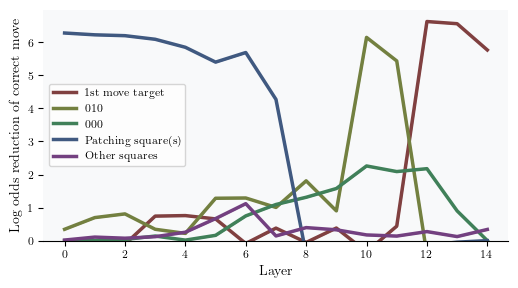

In [202]:
one_puzzle = other_puzzles.iloc[4].to_frame().T
plot_residual_effects(one_puzzle, focus_movements = [("000", "000"), ("010", "010")])

In [204]:
puzzle = other_puzzles.iloc[1]
puzzle.move_tree

{'0': 'g3g7',
 '1': 'd5f7',
 '2': 'd5d7',
 '00': 'h7g7',
 '01': 'h7h8',
 '10': 'c8g8',
 '20': 'c8g8',
 '000': 'd5d7',
 '001': 'g2g3',
 '002': 'g2g4',
 '010': 'd5f7',
 '100': 'g3g6',
 '101': 'h3h2',
 '200': 'd7d5',
 '0000': 'g7f8',
 '1000': 'b4c3',
 '00000': 'd7c8',
 '10000': 'h3h2'}

In [205]:
puzzle

PuzzleId                                                                 0NVfF
FEN                           6r1/6pk/5p1p/2pQpP1P/1qPpP3/6RK/6P1/8 b - - 5 45
Moves                                            g8c8 g3g7 h7g7 d5d7 g7f8 d7c8
Rating                                                                    2049
RatingDeviation                                                             74
Popularity                                                                  95
NbPlays                                                                    956
Themes                         attraction crushing endgame fork long sacrifice
GameUrl                                  https://lichess.org/A0aVENqu/black#89
OpeningTags                                                                NaN
principal_variation                             [g3g7, h7g7, d5d7, g7f8, d7c8]
full_pv_probs                [0.7234101295471191, 0.9624467492103577, 0.955...
full_model_moves                                [g3g